In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.image import imread
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)
В качестве обучающей выборки возьмем часть датасета Flickr Faces, который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. 

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

def denorm(img_tensors):
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    return img_tensors * stats[1][0] + stats[0][0]

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

device(type='cuda', index=0)

In [ ]:
image_size = 64
batch_size = 64
path = '../input/flckr-faces-small-dataset'

trns = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

faces_data = ImageFolder(path, transform=trns)
train_dl = DataLoader(faces_data, batch_size=batch_size, num_workers=2, pin_memory=True)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

Пример картинки из датасета

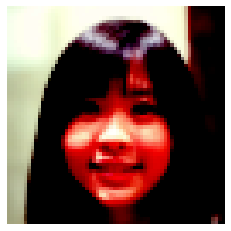

In [ ]:
test_img = next(iter(train_dl))[0][0]
plt.imshow(test_img.permute(1,2,0))
plt.axis('off');

## Часть 2. Построение и обучение модели (2 балла)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
latent_size = 128

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
                nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False), # in: latent_size x 1 x 1
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True), # out: 512 x 4 x 4
                
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True), # out: 256 x 8 x 8
                
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True), # out: 128 x 16 x 16
                
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True), # out: 64 x 32 x 32
                
                nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
                nn.Tanh()) # out: 3 x 64 x 64
        
    def forward(self, x):
        x = self.gen(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discr = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # in: 3 x 64 x 64
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True), # out: 64 x 32 x 32

                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True), # out: 128 x 16 x 16

                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True), # out: 256 x 8 x 8

                nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True), # out: 512 x 4 x 4
                
                nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), 
                nn.Flatten(),
                nn.Sigmoid()) # out: 1 x 1 x 1

    def forward(self, x):
        x = self.discr(x)
        return x

In [ ]:
generator = Generator()

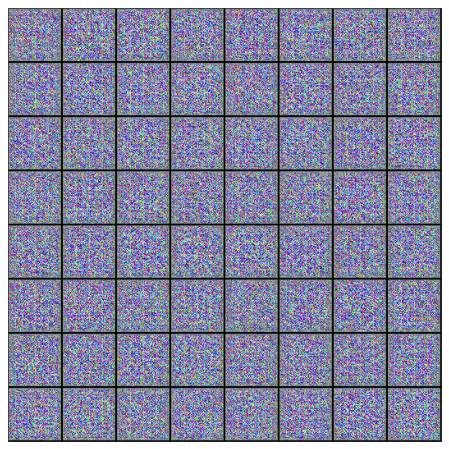

In [ ]:
noise = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(noise)
show_images(fake_images)

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    generator.train()
    discriminator.train()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    lowest_loss_g = np.inf
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.to(device)
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        if losses_g[-1] < lowest_loss_g:
            print(f'Generator score increase from {lowest_loss_g} to {losses_g[-1]}. Saving weights')
            lowest_loss_g = losses_g[-1]
            torch.save(generator.state_dict(), 'gen_best_weights.pth')
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

## Обучение GAN

In [ ]:
lr = 0.0002
epochs = 40

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTransp

In [ ]:
path_weights = None

if path_weights is None:
    history = fit(epochs, lr)
    # Save the model checkpoints 
    torch.save(generator.state_dict(), 'gen_last_weight.pth')
    torch.save(discriminator.state_dict(), 'discriminator.pth')
    losses_g, losses_d, real_scores, fake_scores = history

else:
    generator = Generator()
    generator.load_state_dict(torch.load('../input/generator-weights-2/generator.pth', map_location=torch.device('cpu')))

  0%|          | 0/50 [00:00<?, ?it/s]

Generator score increase from inf to 8.891044616699219. Saving weights
Epoch [1/40], loss_g: 8.8910, loss_d: 0.3277, real_score: 0.7480, fake_score: 0.0005
Saving generated-images-0001.png


  0%|          | 0/50 [00:00<?, ?it/s]

Generator score increase from 8.891044616699219 to 4.294137954711914. Saving weights
Epoch [2/40], loss_g: 4.2941, loss_d: 0.3295, real_score: 0.7920, fake_score: 0.0689
Saving generated-images-0002.png


  0%|          | 0/50 [00:00<?, ?it/s]

Generator score increase from 4.294137954711914 to 1.2291650772094727. Saving weights
Epoch [3/40], loss_g: 1.2292, loss_d: 0.9139, real_score: 0.5429, fake_score: 0.1101
Saving generated-images-0003.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 4.8037, loss_d: 0.3037, real_score: 0.9280, fake_score: 0.1814
Saving generated-images-0004.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 5.4513, loss_d: 0.6215, real_score: 0.8084, fake_score: 0.2753
Saving generated-images-0005.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.6730, loss_d: 0.2567, real_score: 0.9152, fake_score: 0.1337
Saving generated-images-0006.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 7.5106, loss_d: 0.7447, real_score: 0.9774, fake_score: 0.3667
Saving generated-images-0007.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 5.4341, loss_d: 0.2798, real_score: 0.8979, fake_score: 0.1391
Saving generated-images-0008.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 3.2849, loss_d: 0.7822, real_score: 0.5877, fake_score: 0.0300
Saving generated-images-0009.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 6.2761, loss_d: 0.5955, real_score: 0.9473, fake_score: 0.3398
Saving generated-images-0010.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.1865, loss_d: 0.3415, real_score: 0.8800, fake_score: 0.1569
Saving generated-images-0011.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 3.4860, loss_d: 0.5018, real_score: 0.8547, fake_score: 0.2207
Saving generated-images-0012.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.1322, loss_d: 0.3682, real_score: 0.8010, fake_score: 0.0890
Saving generated-images-0013.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.6703, loss_d: 0.2609, real_score: 0.9528, fake_score: 0.1739
Saving generated-images-0014.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.7331, loss_d: 0.3166, real_score: 0.9752, fake_score: 0.2335
Saving generated-images-0015.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.2737, loss_d: 0.2306, real_score: 0.9257, fake_score: 0.1280
Saving generated-images-0016.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 3.7427, loss_d: 0.3447, real_score: 0.8459, fake_score: 0.1442
Saving generated-images-0017.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 3.1671, loss_d: 0.2912, real_score: 0.8407, fake_score: 0.0850
Saving generated-images-0018.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.3416, loss_d: 0.3179, real_score: 0.9703, fake_score: 0.2182
Saving generated-images-0019.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 3.6848, loss_d: 0.3605, real_score: 0.7795, fake_score: 0.0459
Saving generated-images-0020.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 3.7407, loss_d: 0.2950, real_score: 0.8519, fake_score: 0.1054
Saving generated-images-0021.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 6.7106, loss_d: 0.8365, real_score: 0.9679, fake_score: 0.4800
Saving generated-images-0022.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 3.6935, loss_d: 0.2641, real_score: 0.8375, fake_score: 0.0647
Saving generated-images-0023.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 4.9556, loss_d: 0.2109, real_score: 0.9872, fake_score: 0.1576
Saving generated-images-0024.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 5.2140, loss_d: 0.1217, real_score: 0.9339, fake_score: 0.0467
Saving generated-images-0025.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 4.9194, loss_d: 0.1967, real_score: 0.9422, fake_score: 0.1130
Saving generated-images-0026.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 3.7073, loss_d: 0.2708, real_score: 0.8033, fake_score: 0.0352
Saving generated-images-0027.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 5.4824, loss_d: 0.0747, real_score: 0.9491, fake_score: 0.0208
Saving generated-images-0028.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 6.3722, loss_d: 0.3236, real_score: 0.9623, fake_score: 0.1950
Saving generated-images-0029.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 4.5936, loss_d: 0.1249, real_score: 0.9853, fake_score: 0.0978
Saving generated-images-0030.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 5.0493, loss_d: 0.1477, real_score: 0.9354, fake_score: 0.0618
Saving generated-images-0031.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 3.0716, loss_d: 0.7510, real_score: 0.7098, fake_score: 0.1214
Saving generated-images-0032.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 4.8815, loss_d: 0.2585, real_score: 0.9834, fake_score: 0.1986
Saving generated-images-0033.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 5.0683, loss_d: 0.2227, real_score: 0.9945, fake_score: 0.1781
Saving generated-images-0034.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 6.2371, loss_d: 0.1598, real_score: 0.9866, fake_score: 0.1241
Saving generated-images-0035.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 4.4499, loss_d: 0.1329, real_score: 0.9602, fake_score: 0.0784
Saving generated-images-0036.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.0643, loss_d: 0.2032, real_score: 0.9607, fake_score: 0.1387
Saving generated-images-0037.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 4.7101, loss_d: 0.2115, real_score: 0.8414, fake_score: 0.0256
Saving generated-images-0038.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 6.1353, loss_d: 0.1504, real_score: 0.9909, fake_score: 0.1211
Saving generated-images-0039.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 6.2858, loss_d: 0.2030, real_score: 0.9843, fake_score: 0.1494
Saving generated-images-0040.png


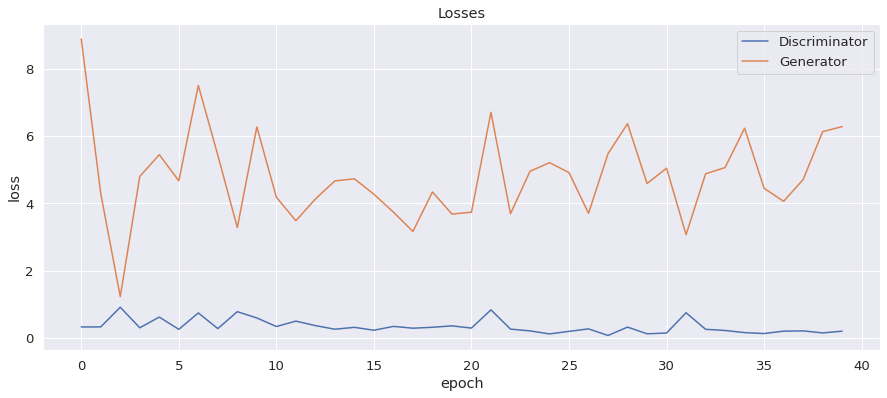

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

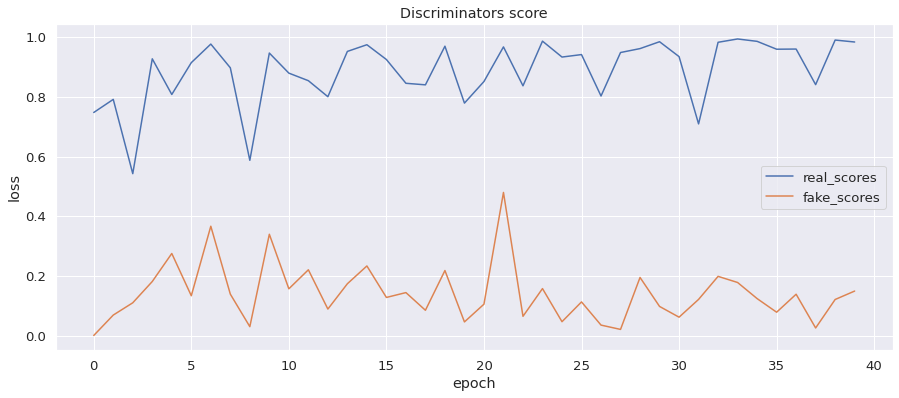

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['real_scores', 'fake_scores'])
plt.title("Discriminators score");

In [ ]:
for file in os.listdir("./generated"):
    path = "./generated/" + file
    img = imread(path)
    plt.figure(figsize = (10,10))
    plt.imshow(img)
    plt.axis('off');

## Часть 3. Генерация изображений (1 балл)


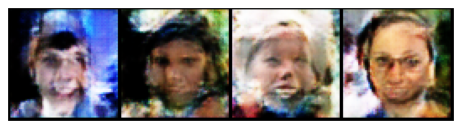

In [ ]:
generator = generator.cpu()
generator.eval()

n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1)
fake_images = generator(fixed_latent)

show_images(fake_images.cpu())

### Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)


Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:

* Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. 
* Присвоить фейковым метку класса 0, настоящим – 1.
* Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. 

В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
cv = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

In [ ]:
generator = Generator()
generator.load_state_dict(torch.load('./gen_last_weight.pth', map_location=torch.device('cpu')))
generator.eval()

noise = torch.randn(len(faces_data), latent_size, 1, 1)

# создаём два тензора: со сгенерированными и настоящими лицами
fake_data = generator(noise)
fake_labels = torch.zeros(fake_data.size(0), 1)

true_data = faces_data
true_labels = torch.ones(len(faces_data), 1)

In [ ]:
# объединяем тензор со сгенерированными и настоящими лицами в один

all_labels = torch.cat((fake_labels, true_labels))

temp = []
for img, _ in tqdm(true_data):
    temp.append(img)
    
all_imgs = torch.cat((fake_data, torch.stack(temp)))

  0%|          | 0/3143 [00:00<?, ?it/s]

In [ ]:
# генерируем случайные индексы
# в LeaveOneOut для оценки передадим 3000 сэмплов

idx = np.arange(len(all_imgs))
np.random.shuffle(idx)
idx = idx[:3000]

In [ ]:
X = all_imgs.view(6286, -1).detach().numpy()[idx]
y = all_labels.detach().numpy().ravel()[idx]

In [ ]:
y[:100]

array([1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [ ]:
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1, verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 84.9min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 123.1min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 167.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 206.2min finished


In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.793 (0.405)


Knn достаточно хорошо отличает сгенерированные изображения от настоящих. Выходит, что GAN создаёт не очень похожие на настоящие лица изображения. 

In [ ]:
# y_true = []
# y_pred = []
# steps = 6285
# for train_index, test_index in cv.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     knn.fit(X_train, y_train)
#     # evaluate model
#     yhat = knn.predict(X_test)
#     # store
#     y_true.append(y_test[0])
#     y_pred.append(yhat[0])
#     steps -= 1
#     print(f'steps {steps} left')
# # calculate accuracy
# acc = accuracy_score(y_true, y_pred)
# print('Accuracy: %.3f' % acc)

### 4.2. Визуализация распределений (2 балла)
Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
X = all_imgs.view(6286, -1).detach().numpy()
y = all_labels.detach().numpy().ravel()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(X)

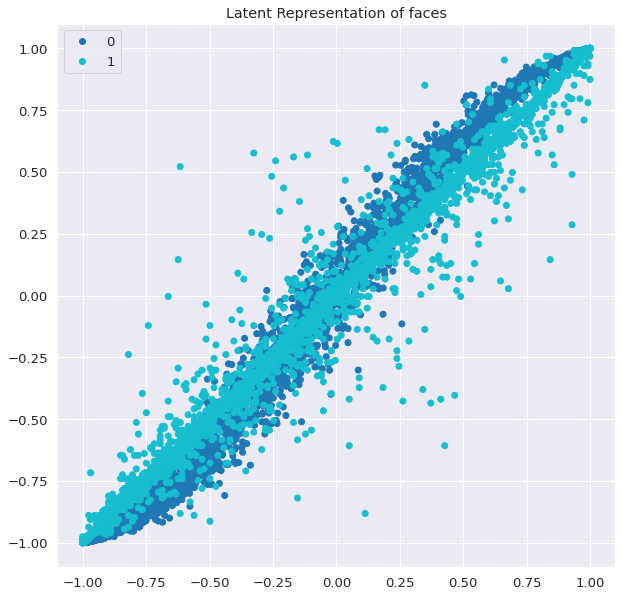

In [ ]:
fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1, 1, 1, title='Latent Representation of faces' )
scatter = ax.scatter(
    x=X[:,0], 
    y=X[:,1], 
    c=y, 
    cmap=plt.cm.get_cmap('tab10'))
    
ax.legend(*scatter.legend_elements(), loc='upper left')
plt.show()